In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq, minimize_scalar
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

# Physical constants in atomic units
HBAR = 1.0
M_ELECTRON = 1.0
HARTREE_TO_EV = 27.211386245988

def effective_potential(r, Z=1, l=0):
    """
    Effective potential in atomic units: V_eff = -Z/r + l(l+1)/(2r^2)
    """
    if r <= 0:
        return np.inf
    coulomb = -Z / r
    centrifugal = l * (l + 1) / (2 * r**2)
    return coulomb + centrifugal

def find_turning_points(E, Z=1, l=0):
    """
    Find classical turning points where E = V_eff(r)
    Returns r1 (inner) and r2 (outer) turning points
    """
    if E >= 0:
        raise ValueError("Energy must be negative for bound states")
    
    if l == 0:
        # For s-orbitals: no centrifugal barrier
        r1 = 0.0
        r2 = -Z / E  # From E = -Z/r
        return r1, r2
    
    # For l > 0: solve V_eff(r) = E numerically
    def potential_diff(r):
        return effective_potential(r, Z, l) - E
    
    # Find minimum of effective potential first
    r_min_result = minimize_scalar(lambda r: effective_potential(r, Z, l), 
                                   bounds=(0.01, 100), method='bounded')
    r_min = r_min_result.x
    V_min = r_min_result.fun
    
    if E <= V_min:
        raise ValueError(f"Energy {E:.6f} is below potential minimum {V_min:.6f}")
    
    # Find inner and outer turning points
    r1 = brentq(potential_diff, 0.001, r_min, xtol=1e-14)
    r2 = brentq(potential_diff, r_min, 500, xtol=1e-14)
    
    return r1, r2

def compute_action_integral(E, Z=1, l=0):
    """
    Compute action integral numerically: ∫[r1 to r2] √(2m[E - V_eff(r)]) dr
    This is the area under the momentum curve between turning points
    """
    try:
        r1, r2 = find_turning_points(E, Z, l)
    except:
        return np.inf
    
    def integrand(r):
        V_eff = effective_potential(r, Z, l)
        if E <= V_eff:
            return 0.0
        momentum_squared = 2 * M_ELECTRON * (E - V_eff)
        if momentum_squared < 0:
            return 0.0
        return np.sqrt(momentum_squared)
    
    # Numerical integration with high precision
    try:
        if l == 0:
            # For s-orbitals, start integration slightly away from r=0 to avoid singularity
            r_start = 1e-10
            integral, error = quad(integrand, r_start, r2, 
                                 limit=1000, epsabs=1e-14, epsrel=1e-12)
        else:
            # For l > 0, normal integration
            integral, error = quad(integrand, r1, r2, 
                                 limit=1000, epsabs=1e-14, epsrel=1e-12)
        
        return integral
    except Exception as e:
        print(f"Integration failed for E={E:.6f}, l={l}: {e}")
        return np.inf

def find_eigenvalue(n, l, Z=1, verbose=False):
    """
    Find energy eigenvalue by searching for E where action integral equals target
    This implements the core algorithm: try different horizontal lines until we find
    the one that gives the correct quantized action
    """
    if l >= n:
        raise ValueError(f"l={l} must be less than n={n}")
    
    # Calculate target quantized action using CORRECT Bohr-Sommerfeld condition
    # For hydrogen: S = 2π·ℏ·(n - l) for full cycle
    # Since we integrate half cycle: target = π·ℏ·(n - l) 
    target_action = np.pi * HBAR * (n - l)
    
    if verbose:
        print(f"\nFinding eigenvalue for n={n}, l={l}")
        print(f"Target action = π × ħ × (n-l) = π × {n-l:.1f} = {target_action:.6f}")
        print(f"Using correct Bohr-Sommerfeld quantization for hydrogen")
    
    def action_error(E):
        """
        Function whose root gives us the eigenvalue
        Returns: computed_action - target_action
        """
        if E >= 0:
            return 1e10  # Large positive error for unbound states
        
        try:
            computed_action = compute_action_integral(E, Z, l)
            error = computed_action - target_action
            
            # Removed iteration printing for cleaner output
            
            return error
        except:
            return 1e10
    
    # Initial guess based on hydrogen-like scaling
    E_guess = -Z**2 / (2 * n**2)
    
    # Set search bounds
    E_min = E_guess * 3.0   # More negative (higher magnitude)
    E_max = E_guess * 0.3   # Less negative (lower magnitude)
    
    # Expand bounds if necessary to bracket the root
    max_attempts = 20
    attempt = 0
    while attempt < max_attempts:
        error_min = action_error(E_min)
        error_max = action_error(E_max)
        
        if error_min * error_max < 0:
            # We have bracketed the root
            break
        elif error_min > 0 and error_max > 0:
            # Both errors positive, need lower energy
            E_min *= 1.5
            E_max *= 1.5
        elif error_min < 0 and error_max < 0:
            # Both errors negative, need higher energy
            E_min *= 0.8
            E_max *= 0.8
        else:
            # One is infinite, adjust
            if error_min == 1e10:
                E_min *= 1.2
            if error_max == 1e10:
                E_max *= 0.8
        
        attempt += 1
    
    if attempt >= max_attempts:
        print(f"Warning: Could not bracket root for n={n}, l={l}. Using guess.")
        return E_guess
    
    # Find the root using Brent's method
    try:
        E_eigenvalue = brentq(action_error, E_min, E_max, 
                             xtol=1e-15, rtol=1e-14, maxiter=1000)
        
        if verbose:
            final_action = compute_action_integral(E_eigenvalue, Z, l)
            print(f"  Final: E = {E_eigenvalue*HARTREE_TO_EV:.6f} eV, Action error = {abs(final_action - target_action):.2e}")
        
        return E_eigenvalue
        
    except Exception as e:
        print(f"Root finding failed for n={n}, l={l}: {e}")
        return E_guess

def calculate_energy_levels(n_max=4, l_max=3, Z=1, verbose=False):
    """
    Calculate all energy levels up to n_max using the action integral method
    """
    energy_levels = {}
    orbital_names = {0: 's', 1: 'p', 2: 'd', 3: 'f', 4: 'g', 5: 'h'}
    
    print(f"Calculating Energy Eigenvalues using Action Integral Method")
    print(f"Nuclear charge Z = {Z}")
    print("="*80)
    print("State      | Quantum Numbers | Calculated (eV) | Analytical (eV) | Error (eV)")
    print("-"*80)
    
    for n in range(1, n_max + 1):
        for l in range(min(n, l_max + 1)):
            # Calculate eigenvalue using action integral method
            E_hartree = find_eigenvalue(n, l, Z, verbose=verbose)
            E_eV = E_hartree * HARTREE_TO_EV
            
            # Compare with analytical hydrogen result
            E_analytical_eV = -13.6 * Z**2 / n**2
            error_eV = abs(E_eV - E_analytical_eV)
            
            # Create orbital name
            orbital_name = f"{n}{orbital_names[l]}"
            
            # Store results
            energy_levels[(n, l)] = {
                'E_hartree': E_hartree,
                'E_eV': E_eV,
                'orbital': orbital_name,
                'analytical_eV': E_analytical_eV,
                'error_eV': error_eV
            }
            
            print(f"{orbital_name:8} | n={n}, l={l} | {E_eV:12.6f} | {E_analytical_eV:12.3f} | {error_eV:9.6f}")
    
    return energy_levels

def plot_potential(Z=1, l_values=[0, 1, 2], r_max=20):
    """
    Plot effective potential curves for different l values
    """
    r = np.linspace(0.1, r_max, 1000)
    
    fig, axes = plt.subplots(1, len(l_values), figsize=(5*len(l_values), 6))
    if len(l_values) == 1:
        axes = [axes]
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
    
    for idx, l in enumerate(l_values):
        ax = axes[idx]
        
        # Calculate potential
        V_eff = np.array([effective_potential(ri, Z, l) for ri in r])
        
        # Set reasonable y-limits
        if l == 0:
            y_min, y_max = -3, 1
        else:
            # Find minimum for l > 0
            r_min_result = minimize_scalar(lambda r: effective_potential(r, Z, l), 
                                         bounds=(0.1, 20), method='bounded')
            V_min = r_min_result.fun
            y_min = max(V_min - 1, -3)
            y_max = 1
        
        # Clip potential for plotting
        V_eff_plot = np.clip(V_eff, y_min, y_max)
        
        # Plot potential curve
        ax.plot(r, V_eff_plot, colors[idx % len(colors)], linewidth=2, 
                label=f'$V_{{eff}}(r)$ for l={l}')
        
        # Add reference lines
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, 
                  label='E=0 (ionization)')
        
        ax.set_xlabel('r (Bohr radii)', fontsize=12)
        ax.set_ylabel('Energy (Hartree)', fontsize=12)
        orbital_type = ['s', 'p', 'd', 'f'][l] if l < 4 else f'l={l}'
        ax.set_title(f'l = {l} ({orbital_type} orbitals)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(y_min, y_max)
        ax.legend()
    
    plt.suptitle(f'Effective Potential for Z={Z}', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_energy_levels_on_potential(energy_levels, Z=1, l_values=[0, 1, 2], r_max=15):
    """
    Plot energy levels as horizontal lines on the potential curves
    This shows exactly what the algorithm is doing: finding horizontal lines
    where the area between the line and curve gives the correct action
    """
    r = np.linspace(0.1, r_max, 1000)
    
    fig, axes = plt.subplots(1, len(l_values), figsize=(5*len(l_values), 8))
    if len(l_values) == 1:
        axes = [axes]
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
    
    for idx, l in enumerate(l_values):
        ax = axes[idx]
        
        # Calculate potential
        V_eff = np.array([effective_potential(ri, Z, l) for ri in r])
        
        # Determine y-limits based on energy levels for this l
        energies_this_l = [data['E_hartree'] for (n, l_val), data in energy_levels.items() 
                          if l_val == l]
        
        if energies_this_l:
            E_min = min(energies_this_l)
            if l == 0:
                y_min = max(E_min - 0.5, -2.5)
                y_max = 0.5
            else:
                r_min_result = minimize_scalar(lambda r: effective_potential(r, Z, l), 
                                             bounds=(0.1, 20), method='bounded')
                V_min = r_min_result.fun
                y_min = max(min(V_min - 0.3, E_min - 0.3), -2.5)
                y_max = 0.5
        else:
            y_min, y_max = -2.5, 0.5
        
        # Clip potential for plotting
        V_eff_plot = np.clip(V_eff, y_min, y_max)
        
        # Plot potential curve
        ax.plot(r, V_eff_plot, colors[idx % len(colors)], linewidth=2.5, 
                label=f'$V_{{eff}}(r)$')
        
        # Plot each energy level as a horizontal line
        for (n, l_val), level_data in energy_levels.items():
            if l_val == l and y_min <= level_data['E_hartree'] <= y_max:
                E = level_data['E_hartree']
                orbital = level_data['orbital']
                
                try:
                    # Find turning points for this energy
                    r1, r2 = find_turning_points(E, Z, l)
                    
                    # Plot horizontal line between turning points
                    r_line_start = max(r1, r[0])
                    r_line_end = min(r2, r_max)
                    
                    if r_line_start < r_line_end:
                        # Plot horizontal energy level as thin dashed black line
                        ax.hlines(E, r_line_start, r_line_end, colors='black', 
                                linestyle='--', linewidth=1.5, alpha=0.8)
                        
                        # Add energy level label
                        label_x = min(r_line_end + 0.2, r_max - 1)
                        ax.text(label_x, E, f'{orbital}: {level_data["E_eV"]:.3f} eV', 
                               fontsize=9, verticalalignment='center',
                               bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
                        
                        # Mark turning points with small dots
                        if r1 < r_max and r1 >= r[0]:
                            ax.plot(r1, E, 'ko', markersize=3)
                        if r2 < r_max:
                            ax.plot(r2, E, 'ko', markersize=3)
                
                except Exception as e:
                    print(f"Could not plot energy level for n={n}, l={l}: {e}")
                    continue
        
        ax.set_xlabel('r (Bohr radii)', fontsize=12)
        ax.set_ylabel('Energy (Hartree)', fontsize=12)
        orbital_type = ['s', 'p', 'd', 'f'][l] if l < 4 else f'l={l}'
        ax.set_title(f'l = {l} ({orbital_type}) Energy Levels', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(y_min, y_max)
        ax.set_xlim(0, r_max)
    
    plt.suptitle(f'Energy Eigenvalues from Action Integral Method (Z={Z})', fontsize=14)
    plt.tight_layout()
    plt.show()

def test_single_calculation(n=1, l=0, Z=1):
    """
    Test a single energy level calculation with detailed output
    """
    print(f"DETAILED CALCULATION FOR n={n}, l={l}, Z={Z}")
    print("="*50)
    
    target_action = np.pi * HBAR * (n - l)
    print(f"Target action = π × ({n}-{l}) = {target_action:.8f}")
    print("Using correct Bohr-Sommerfeld quantization: S = 2π·ℏ·(n-l)")
    print("For half-cycle integration: target = π·ℏ·(n-l)")
    
    E_result = find_eigenvalue(n, l, Z, verbose=True)
    E_analytical = -Z**2 / (2 * n**2)
    
    print(f"\nComparison:")
    print(f"Calculated: {E_result:.8f} Hartree = {E_result*HARTREE_TO_EV:.6f} eV")
    print(f"Analytical: {E_analytical:.8f} Hartree = {E_analytical*HARTREE_TO_EV:.6f} eV")
    print(f"Error: {abs(E_result - E_analytical)*HARTREE_TO_EV:.8f} eV");

In [19]:
print("=== Numerical Action Integral Energy Calculator ===")

Z = 1  # Hydrogen
print(f"Testing with Z = {Z}")

# Cell 2: Test detailed calculation for ground state
test_single_calculation(n=1, l=0, Z=Z)


=== Numerical Action Integral Energy Calculator ===
Testing with Z = 1
DETAILED CALCULATION FOR n=1, l=0, Z=1
Target action = π × (1-0) = 3.14159265
Using correct Bohr-Sommerfeld quantization: S = 2π·ℏ·(n-l)
For half-cycle integration: target = π·ℏ·(n-l)

Finding eigenvalue for n=1, l=0
Target action = π × ħ × (n-l) = π × 1.0 = 3.141593
Using correct Bohr-Sommerfeld quantization for hydrogen
  Final: E = -13.605693 eV, Action error = 1.26e-13

Comparison:
Calculated: -0.50000000 Hartree = -13.605693 eV
Analytical: -0.50000000 Hartree = -13.605693 eV
Error: 0.00000000 eV


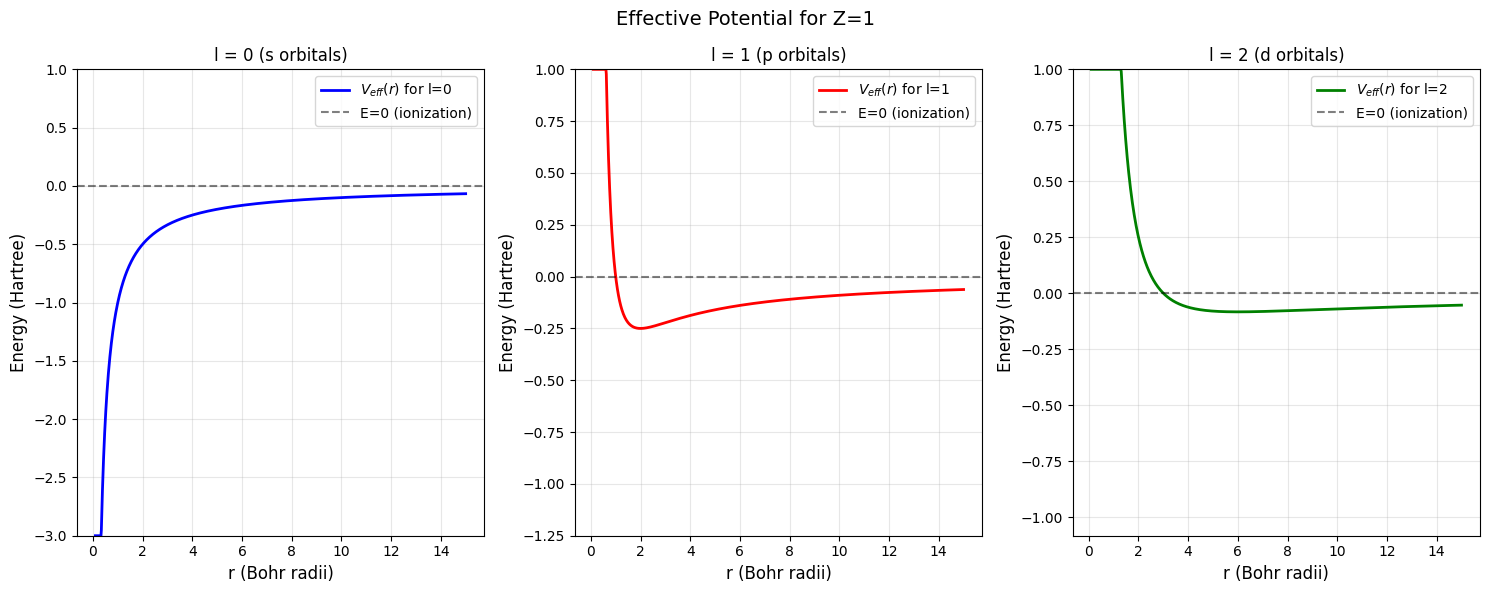

In [20]:
Z = 1

# Plot potentials
plot_potential(Z=Z, l_values=[0, 1, 2], r_max=15)

Calculating Energy Eigenvalues using Action Integral Method
Nuclear charge Z = 1
State      | Quantum Numbers | Calculated (eV) | Analytical (eV) | Error (eV)
--------------------------------------------------------------------------------
1s       | n=1, l=0 |   -13.605693 |      -13.600 |  0.005693
2s       | n=2, l=0 |    -3.401423 |       -3.400 |  0.001423
2p       | n=2, l=1 |    -6.802847 |       -3.400 |  3.402847
3s       | n=3, l=0 |    -1.511744 |       -1.511 |  0.000633
3p       | n=3, l=1 |    -1.167184 |       -1.511 |  0.343927
3d       | n=3, l=2 |    -2.267616 |       -1.511 |  0.756504


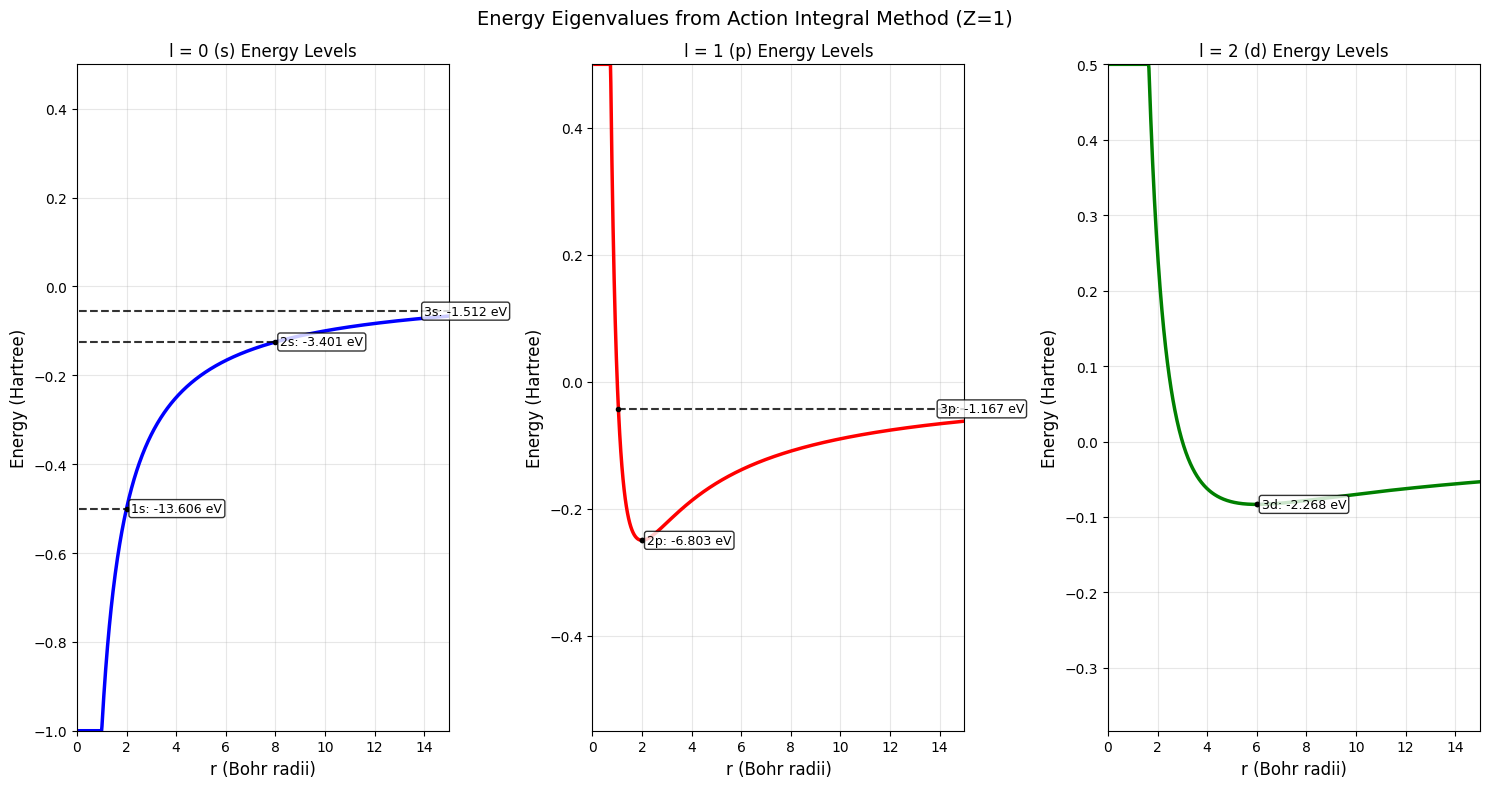

In [21]:
# Calculate all energy levels
energy_levels = calculate_energy_levels(n_max=3, l_max=2, Z=Z)

# Visualize energy levels on potentials
plot_energy_levels_on_potential(energy_levels, Z=Z, l_values=[0, 1, 2], r_max=15)